In [193]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.decomposition import PCA

In [2]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.
/Users/kohler/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kohler/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kohler/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kohler/anaconda3/lib/python3.7/site-packages/t

In [3]:
combined_file = './data/wallpapers-sorting-image.csv'
combined_data = pd.read_csv(combined_file, header=0, index_col=False, keep_default_na=True)

In [265]:
def image_preprocess(image_path):
    image = load_img(image_path, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    return image

def image_dotprod(img1, img2):
    #mask1 = np.tile(np.reshape(~np.all(img1 == 128, axis = -1), [600,600,1]),[1,1,3])
    #mask2 = np.tile(np.reshape(~np.all(img2 == 128, axis = -1), [600,600,1]),[1,1,3])
    #assert np.all(mask1 == mask2)
    img1 = np.reshape(img1, [1, -1])
    img2 = np.reshape(img2, [1, -1])
    dotp = np.dot(img1, img2.T) / (np.linalg.norm(img1)*np.linalg.norm(img2))
    return dotp

def image_label(image, model):
    # predict the probability across all output classes
    yhat = model.predict(image, verbose=True)
    # convert the probabilities to class labels
    label = decode_predictions(yhat)
    # retrieve the most likely result, e.g. highest probability
    label = label[0][0]
    # print the classification
    print('%s (%.2f%%)' % (label[1], label[2]*100))

    return label

In [266]:
## build similarity matrix
# load the model
model = VGG16()
# get fully connected layer output
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('fc1').output)

group_list = combined_data["Group"].unique()
jaccard_list = []
ssid_list = []
dot_list = []
cnn_list = []
n_comp = []
full_act = []
full_ex = []
full_raw = []

for group in group_list:
    cur_data = combined_data[combined_data["Group"]==group]
    ex_list = list(cur_data["Exemplar_1"].append(cur_data["Exemplar_2"]).unique())
    jaccard_mat = np.ones((len(ex_list), len(ex_list)))
    ssid_mat = np.ones((len(ex_list), len(ex_list)))
    dot_mat = np.ones((len(ex_list), len(ex_list)))
    cnn_mat = np.ones((len(ex_list), len(ex_list)))
    
    # load in images
    raw_list = [ img_to_array(load_img('../img/{0}-{1}.png'.format(group, int(str(x)[-3:])))) for x in ex_list ]
    
    # apply intermediate model to images
    image_list = [ image_preprocess('../img/{0}-{1}.png'.format(group, int(str(x)[-3:]))) for x in ex_list ]
    
    fc1_act = intermediate_layer_model.predict(np.array(image_list).squeeze())
    
    # use PCA for dimensionality reduction
    pca = PCA(n_components = 0.95, svd_solver = 'full').fit(fc1_act)
    fc1_xform = pca.transform(fc1_act)
    n_comp.append(fc1_xform.shape[-1])
    for idx1, ex1 in enumerate(ex_list):
        for idx2, ex2 in enumerate(ex_list):
            cur_idx = (cur_data["Exemplar_1"] == ex1) & (cur_data["Exemplar_2"] == ex2)
            if not cur_data[cur_idx]["Jaccard"].empty:
                jaccard_mat[idx1, idx2] = cur_data[cur_idx]["Jaccard"].to_numpy()
                ssid_mat[idx1, idx2] = cur_data[cur_idx]["SSID"].to_numpy()
                dot_mat[idx1, idx2] = cur_data[cur_idx]["Dot_Prod"].to_numpy()
                cnn_mat[idx1, idx2] = np.corrcoef(fc1_xform[idx1, :], fc1_xform[idx2, :])[0,1]
                test = image_dotprod(raw_list[idx1], raw_list[idx2])
                assert math.isclose(dot_mat[idx1, idx2], test, abs_tol=0.00001)
                
    jaccard_list.append(pd.DataFrame(jaccard_mat, columns = ex_list, index = ex_list))
    ssid_list.append(pd.DataFrame(ssid_mat, columns = ex_list, index = ex_list))
    dot_list.append(pd.DataFrame(dot_mat, columns = ex_list, index = ex_list))
    cnn_list.append(pd.DataFrame(cnn_mat, columns = ex_list, index = ex_list))
    
    # run pca again, with same # components for all groups
    new_pca = PCA(n_components = 15, svd_solver = 'full').fit(fc1_act)
    full_act = full_act + new_pca.transform(fc1_act).tolist()
    full_raw = full_raw + raw_list
    full_ex = full_ex + ex_list
    
    print(group)
    

P1
P31M
P3M1
P6
P6M


In [267]:
n_comp

[14, 13, 14, 14, 15]

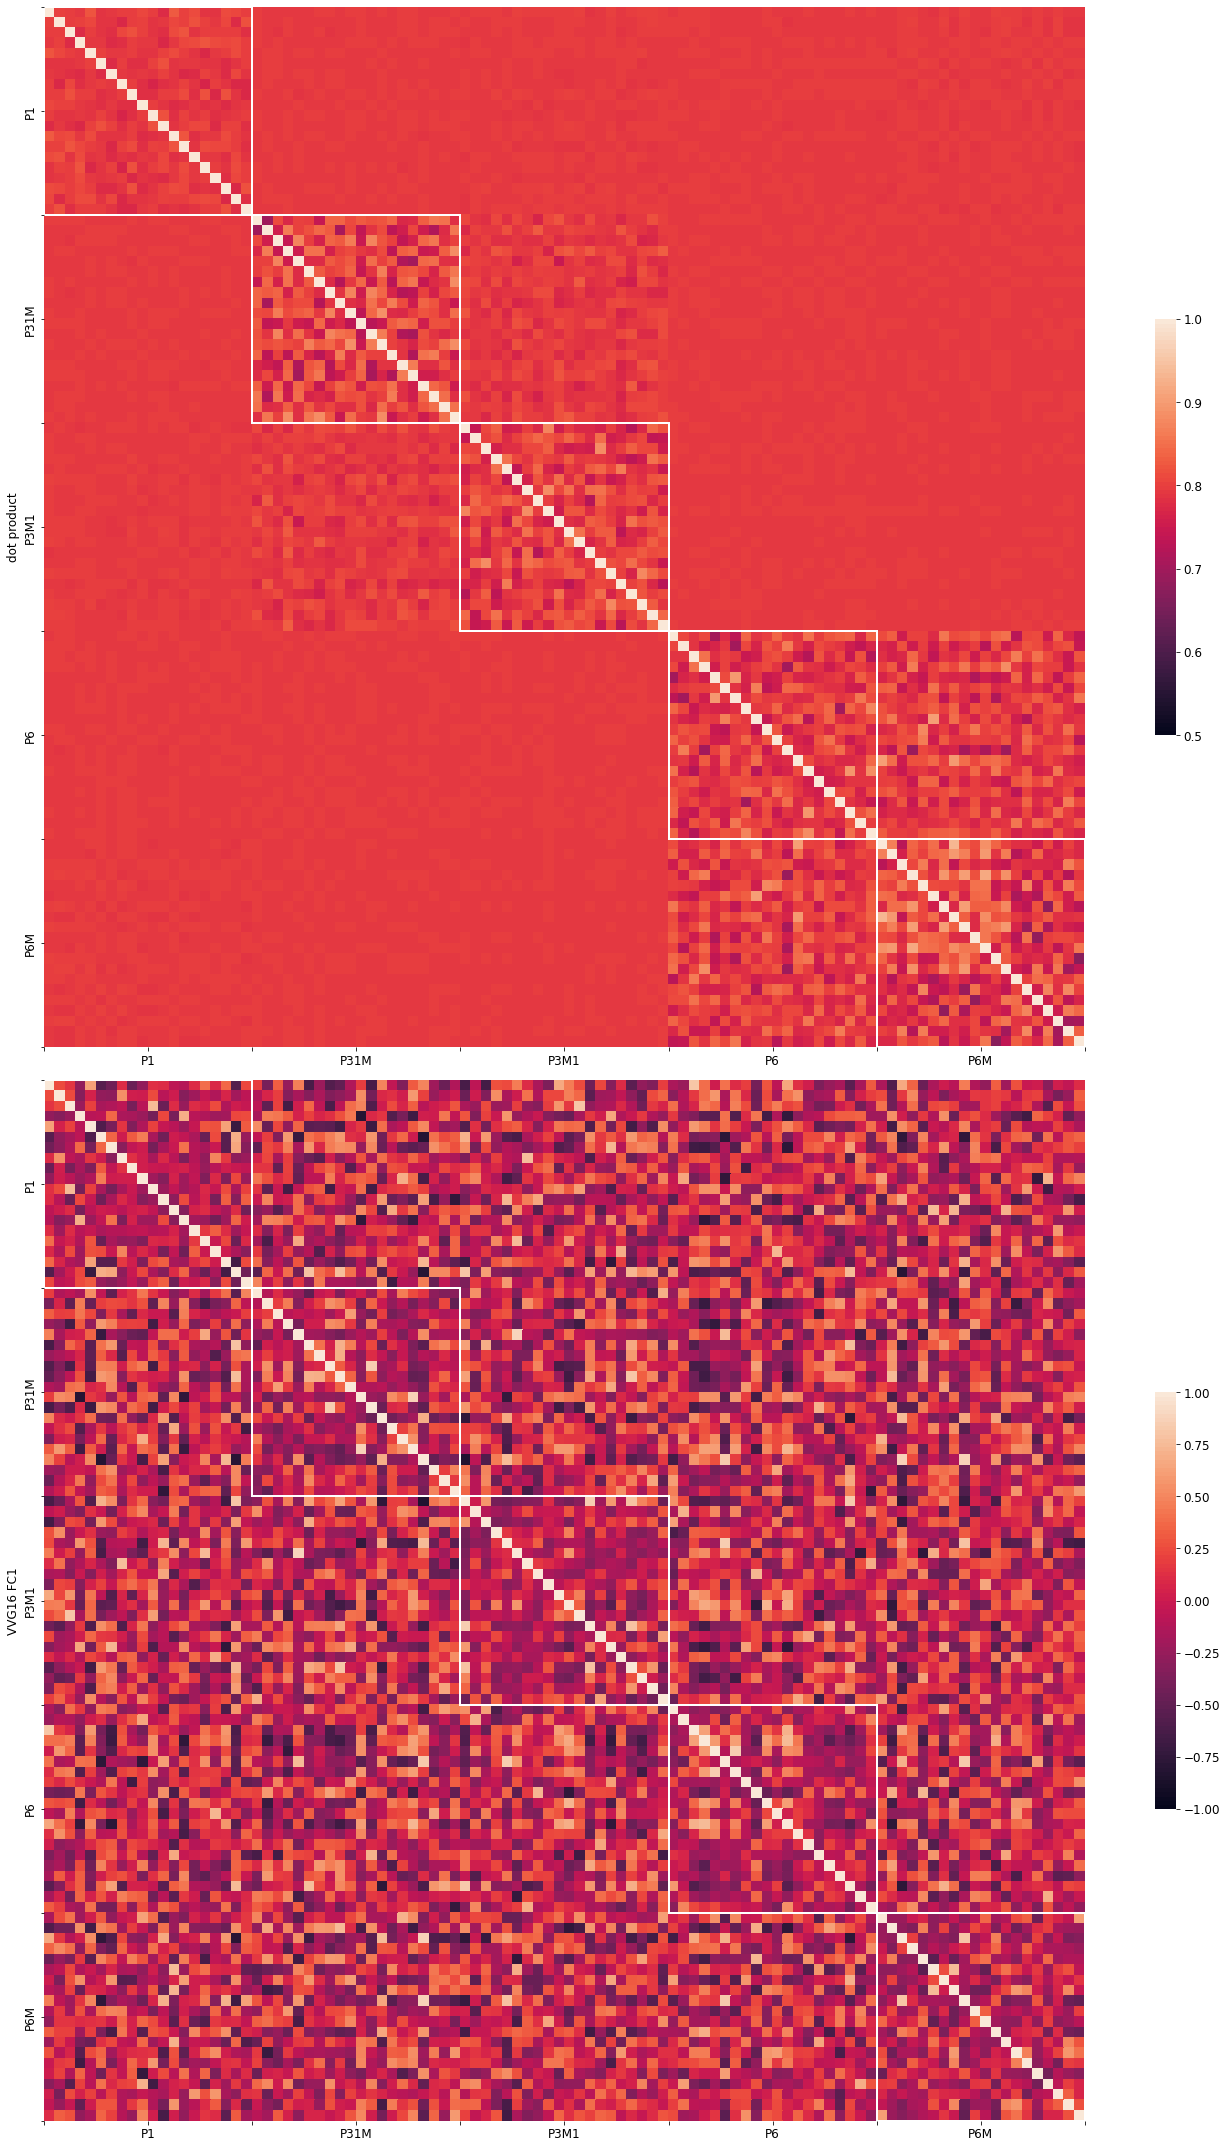

In [300]:
# make full similarity matrix

name_full = []
for x in group_list.tolist(): name_full += ['', x] 
name_full += ['']

full_cnn = np.ones((len(full_ex), len(full_ex)))
full_dotp = np.ones((len(full_ex), len(full_ex)))

for idx1, ex1 in enumerate(full_ex):
    for idx2, ex2 in enumerate(full_ex):
            full_cnn[idx1, idx2] = np.corrcoef(full_act[idx1], full_act[idx2])[0,1]
            full_dotp[idx1, idx2] = image_dotprod(full_raw[idx1], full_raw[idx2])

full_cnn = pd.DataFrame(full_cnn, columns = full_ex, index = full_ex)
full_dotp = pd.DataFrame(full_dotp, columns = full_ex, index = full_ex)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,30))
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

for t in range(2): 
    if t == 0:
        cur_range = [ .5, 1 ]
        cur_mat = full_dotp
        title_str = 'dot product'
    else:
        cur_range = [ -1, 1 ]
        cur_mat = full_cnn
        title_str = 'VVG16 FC1'
        
    sns.heatmap(cur_mat,
              ax=ax[t], vmin=cur_range[0], vmax=cur_range[1], cbar=True, cbar_kws={'shrink':.4}, cmap=sns.color_palette("rocket", 100), square=True)
  
    pH = [ ax[t].add_patch(patches.Rectangle((x,x),20,20,linewidth=2,edgecolor='w',facecolor='none')) for x in [0,20,40,60,80] ]
    ax[t].set_xticks(np.arange(0, cur_mat.shape[0]+10, 10))
    ax[t].set_yticks(np.arange(0, cur_mat.shape[0]+10, 10))
    ax[t].set_xticklabels(name_full, rotation = 0, ha="center")
    ax[t].set_yticklabels(name_full, rotation = 90, va="center")
    ax[t].set_ylabel(title_str)
    
plt.tight_layout()
plt.savefig('../writeup/figures/similarity_full.pdf')

In [301]:
sym_score = []
for prefix in list(set([int(str(x)[1:4]) for x in full_list])):
    sub_list = [prefix * 1000 + x for x in range(1,21,1)]
    sub_mat = full_dotp[full_mat.index.isin(sub_list)]
    in_mat = sub_mat[[c for c in sub_mat.columns if c in sub_list]]
    out_mat = sub_mat[[c for c in sub_mat.columns if c not in sub_list]]
    in_mean = in_mat.replace(1, np.NaN).mean().mean()
    out_mean = out_mat.replace(1, np.NaN).mean().mean()
    sym_score.append((in_mean - out_mean)/out_mean)

In [302]:
sym_score

[0.007321518810476013,
 0.012932739315045527,
 0.013398326730635091,
 0.003913926348450779,
 0.010737253171198852]

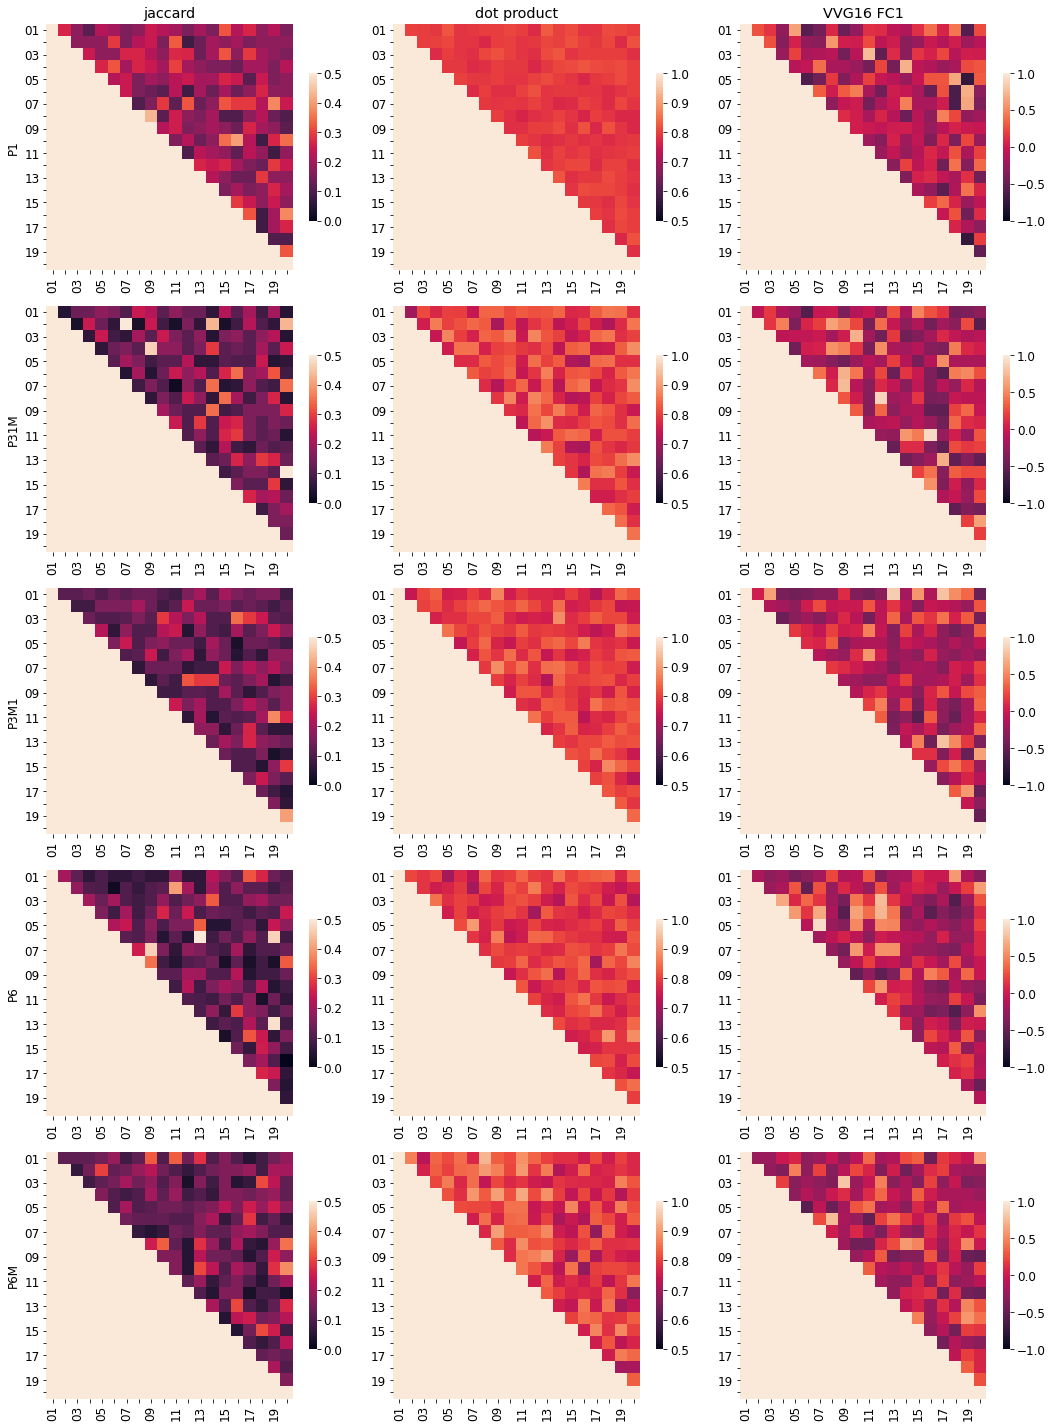

In [231]:
name_list = [str(x)[-2:] for x in ex_list]
name_list[1::2]= [''] * 10
fig, ax = plt.subplots(nrows=len(group_list), ncols=3, figsize=(15,20))
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
corr_vals = np.zeros((len(group_list), 4))
for n, group in enumerate(group_list):
    for t in range(3): 
        if t == 0:
            cur_mat = jaccard_list[n]
            cur_range = [ 0, .5 ]
            title_str = 'jaccard'
        elif t == 1:
            cur_mat = dot_list[n]
            cur_range = [ .5, 1 ]
            title_str = 'dot product'
        else:
            cur_mat = cnn_list[n]
            cur_range = [ -1, 1 ]
            title_str = 'VVG16 FC1'
        pos = sns.heatmap(cur_mat,
              ax=ax[n,t], vmin=cur_range[0], vmax=cur_range[1], cbar=True, cbar_kws={'shrink':.6}, cmap=sns.color_palette("rocket", 100), square=True)
        # We want to show all ticks...
        ax[n,t].set_xticks(np.arange(len(name_list))+.5)
        ax[n,t].set_yticks(np.arange(len(name_list))+.5)
        # ... and label them with the respective list entries
        ax[n,t].set_xticklabels(name_list)
        ax[n,t].set_yticklabels(name_list)
        
        if n == 0:
            ax[n,t].set_title(title_str)
        if t == 0:
            ax[n,t].set_ylabel(group)
    mat_idx = np.triu_indices(jaccard_list[n].shape[0], 1)
    corr_vals[n,0] = np.corrcoef(jaccard_list[n].values[mat_idx], ssid_list[n].values[mat_idx])[0,1]
    corr_vals[n,1] = np.corrcoef(jaccard_list[n].values[mat_idx], dot_list[n].values[mat_idx])[0,1]
    corr_vals[n,2] = np.corrcoef(jaccard_list[n].values[mat_idx], cnn_list[n].values[mat_idx])[0,1]
    corr_vals[n,3] = np.corrcoef(ssid_list[n].values[mat_idx], dot_list[n].values[mat_idx])[0,1]
plt.tight_layout()
plt.savefig('../writeup/figures/similarity_comparison.pdf')